In [1]:
from facet_ml.classification import cnn
import torch
from torch import nn
import numpy as np
from torchvision.models import resnet152


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# Load data
csv_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\CC_Manuscript_Data\Training_Data_20240216\2024_02_27_Processed.csv"
h5_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\CC_Manuscript_Data\Training_Data_20240216\2024_02_16_Training.h5"
dataloaders, datasizes = cnn.load_colloidal_datasets_h5(
    csv_file=csv_path,
    h5_file=h5_path,
    num_workers=4,
    batch_size=16,
    split_frac=0.7,
    stratify=True,
    three_class_mode=True,
)
check_input, check_output = next(iter(dataloaders["test"]))

c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


cuda


In [2]:
from tempfile import TemporaryDirectory
import time
import os

def train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    dataloaders: dict,
    dataset_sizes: dict,
):
    """
    Train num_epochs
    """
    since = time.time()

    # Create a temporary directory to save training checkpoints
    loss_dict = {"train": [], "test": []}
    accuracy_dict = {"train": [], "test": []}
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "test"]:
                regions = []
                actual = []
                logits = []
                results = []
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    regions.append(inputs)
                    actual.append(labels)

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        preds = torch.argmax(outputs, 1)
                        logits.append(outputs)
                        results.append(preds)
                        # print("Outputs and Preds", outputs.shape, preds.shape)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = (running_corrects.double() / dataset_sizes[phase]).cpu()

                loss_dict[phase].append(epoch_loss)
                accuracy_dict[phase].append(epoch_acc)

                print(
                    f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, ({running_corrects}/{dataset_sizes[phase]})"
                )

                # deep copy the model
                if phase == "test" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path)) # Is this bugged?
    return model, loss_dict, accuracy_dict, regions, actual, logits, results

Epoch 0/9
----------
train Loss: 0.6400 Acc: 0.7270, (1185/1630)
test Loss: 0.5661 Acc: 0.7426, (303/408)

Epoch 1/9
----------
train Loss: 0.4956 Acc: 0.7945, (1295/1630)
test Loss: 0.5244 Acc: 0.8015, (327/408)

Epoch 2/9
----------
train Loss: 0.4282 Acc: 0.8282, (1350/1630)
test Loss: 0.3624 Acc: 0.8505, (347/408)

Epoch 3/9
----------
train Loss: 0.4003 Acc: 0.8276, (1349/1630)
test Loss: 0.3504 Acc: 0.8676, (354/408)

Epoch 4/9
----------
train Loss: 0.3389 Acc: 0.8607, (1403/1630)
test Loss: 0.3491 Acc: 0.8627, (352/408)

Epoch 5/9
----------
train Loss: 0.3573 Acc: 0.8374, (1365/1630)
test Loss: 0.3478 Acc: 0.8627, (352/408)

Epoch 6/9
----------
train Loss: 0.3453 Acc: 0.8491, (1384/1630)
test Loss: 0.3424 Acc: 0.8652, (353/408)

Epoch 7/9
----------
train Loss: 0.3406 Acc: 0.8620, (1405/1630)
test Loss: 0.3398 Acc: 0.8652, (353/408)

Epoch 8/9
----------
train Loss: 0.3527 Acc: 0.8417, (1372/1630)
test Loss: 0.3401 Acc: 0.8750, (357/408)

Epoch 9/9
----------
train Loss: 0.33

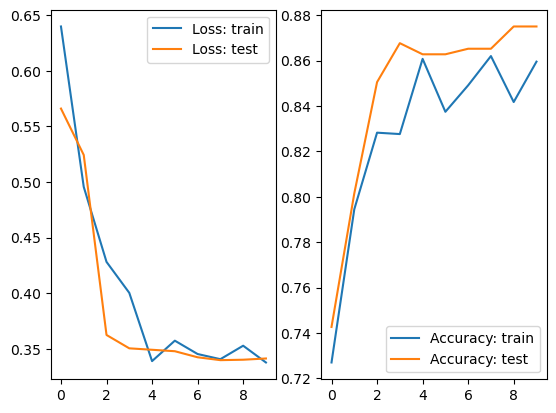

In [3]:
# Load model
model = cnn.get_model(3, resnet152(weights="DEFAULT"))
# model = cnn.UNet(3, 5)
model.to(device=device)

## Get model trianing information
criterion = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=0.005, momentum=0.9, weight_decay= 0.0001#0.01  # 0.0001
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model, loss_dict, accuracy_dict, regions, actual, logits, results=train_model(
    model,
    criterion,
    optimizer,
    lr_scheduler,
    num_epochs=10,
    dataloaders=dataloaders,
    dataset_sizes=datasizes,
)
# Make quick plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2)
for ii, key in enumerate(loss_dict.keys()):
    # ax = axes[ii]
    x = np.array(range(len(loss_dict[key])))

    for ii, (label, dict_oi) in enumerate(
        [("Loss", loss_dict), ("Accuracy", accuracy_dict)]
    ):
        ax = axes[ii]
        y = np.array(dict_oi[key])

        ax.plot(x, y, label=f"{label}: {key}")
        ax.legend()


torch.save(model.state_dict(), "resnet152_trained_dict.pth")
torch.save(model, "resnet152_trained.pth")